# Keypoint Classification

## Import

In [126]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

In [ ]:
KEYPOINT_DATA = '../DATA/keypoint/keypoint.csv'
KEYPOINT_KERAS_MODEL = '../model/keypoint_classifier/keypoint_classifier.keras'
KEYPOINT_TFLITE_MODEL = '../model/keypoint_classifier/keypoint_classifier.tflite'
KEYPOINT_LOGS =  '../model/keypoint_classifier/keypoint_logs'
# KEYPOINT_MODEL_CHECKPOINT = '../model/keypoint_classifier/keypoint_classifier.weights.h5'

## Load Data

In [3]:
HAND_LANDMARK = 21
DIMENSION = 2

In [4]:
X_full = np.loadtxt(KEYPOINT_DATA, delimiter=',', dtype='float32', usecols=list(range(1, (HAND_LANDMARK * DIMENSION) + 1)))
y_full = np.loadtxt(KEYPOINT_DATA, delimiter=',', dtype='int32', usecols=(0)) 

In [5]:
X_full

array([[ 0.        ,  0.        ,  0.2007874 , ..., -0.68503934,
        -0.22047244, -0.78740156],
       [ 0.        ,  0.        ,  0.20634921, ..., -0.6904762 ,
        -0.21031746, -0.7936508 ],
       [ 0.        ,  0.        ,  0.20238096, ..., -0.68650794,
        -0.21428572, -0.78968257],
       ...,
       [ 0.        ,  0.        , -0.2711111 , ..., -0.8933333 ,
        -0.12444445, -1.        ],
       [ 0.        ,  0.        , -0.26548672, ..., -0.8938053 ,
        -0.13716814, -1.        ],
       [ 0.        ,  0.        , -0.25652173, ..., -0.8869565 ,
        -0.1173913 , -1.        ]], dtype=float32)

In [6]:
NUM_CLASSES = len(np.unique(y_full))
print(NUM_CLASSES)

4


## Split Data

In [50]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

In [51]:
X_train.shape

(3063, 42)

In [52]:
X_valid.shape

(766, 42)

In [53]:
X_test.shape

(958, 42)

## Searching optimal learning rate

In [117]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [118]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [119]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(HAND_LANDMARK * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
])

In [120]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [121]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2178 - loss: 1.6469 - val_accuracy: 0.1658 - val_loss: 1.5581


Text(0, 0.5, 'Loss')

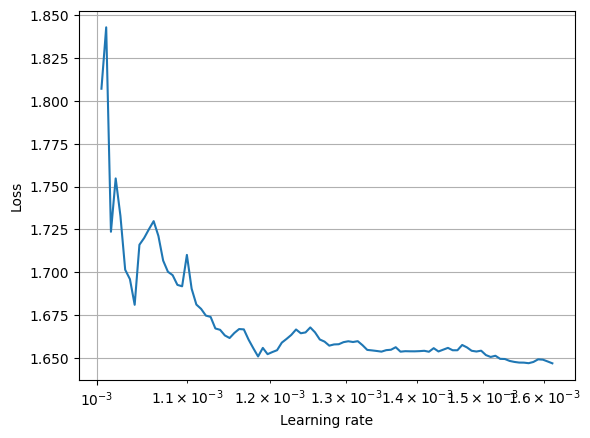

In [123]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
# plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
# plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

## Train Model

In [140]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [141]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(HAND_LANDMARK * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
])

In [142]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,114 (4.35 KB)

 Trainable params: 1,114 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.15e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [144]:
run_index = 1 # increment this at every run
run_logdir = Path(KEYPOINT_LOGS) / "run_{:03d}".format(run_index)
run_logdir

PosixPath('../model/keypoint_classifier/keypoint_logs/run_001')

In [145]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(KEYPOINT_KERAS_MODEL, save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [146]:
history = model.fit(X_train, y_train, epochs=1000,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1610 - loss: 1.5732 - val_accuracy: 0.1736 - val_loss: 1.4506
Epoch 2/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2112 - loss: 1.4947 - val_accuracy: 0.2794 - val_loss: 1.3913
Epoch 3/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2579 - loss: 1.4398 - val_accuracy: 0.3499 - val_loss: 1.3522
Epoch 4/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3026 - loss: 1.3900 - val_accuracy: 0.4008 - val_loss: 1.3254
Epoch 5/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3235 - loss: 1.3726 - val_accuracy: 0.4125 - val_loss: 1.3046
Epoch 6/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3301 - loss: 1.3537 - val_accuracy: 0.4021 - val_loss: 1.2888
Epoch 7/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3470 - loss: 1.3397 - val_accuracy: 0.3995 - val_loss: 1.2755
Epoch 8/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3575 - loss: 1.3288 - val_accuracy: 0.

In [153]:
model = tf.keras.models.load_model(KEYPOINT_KERAS_MODEL) # rollback to best model
model.evaluate(X_test, y_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9478 - loss: 0.2581  


[0.2580615282058716, 0.9478079080581665]

In [154]:
print(KEYPOINT_LOGS)
for path in sorted(Path(KEYPOINT_LOGS).glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

../model/keypoint_classifier/keypoint_logs
        run_001
          train
            events.out.tfevents.1755158574.LAPTOPTHNNDAT.7506.0.v2
            events.out.tfevents.1755158663.LAPTOPTHNNDAT.7506.2.v2
          validation
            events.out.tfevents.1755158575.LAPTOPTHNNDAT.7506.1.v2
            events.out.tfevents.1755158663.LAPTOPTHNNDAT.7506.3.v2


In [156]:
%load_ext tensorboard
%tensorboard --logdir=../model/keypoint_classifier/keypoint_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 111143), started 0:02:53 ago. (Use '!kill 111143' to kill it.)

## Convert to TFLITE


In [157]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open(KEYPOINT_TFLITE_MODEL, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvhbih841/assets


INFO:tensorflow:Assets written to: /tmp/tmpvhbih841/assets


Saved artifact at '/tmp/tmpvhbih841'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135756019740944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135756018396928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135756018397632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135756018387072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135756018400448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135756018392176: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1755159301.690193    7506 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1755159301.690281    7506 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-08-14 15:15:01.690476: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvhbih841
2025-08-14 15:15:01.691013: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-14 15:15:01.691024: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpvhbih841
2025-08-14 15:15:01.699620: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-14 15:15:01.725911: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpvhbih841
2025-08-14 15:15:01.734408: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 43935 microseconds.
